In [1]:
# Setup: Pull latest code and install package with CUDA support
# Run this cell first. If imports fail, restart kernel and run again.

import subprocess
import sys
import os

REPO_URL = "https://github.com/JackHopkins/FormationHNCA.git"

# Detect environment and set repo path
if os.path.exists("/content"):  # Google Colab
    REPO_DIR = "/content/FormationHNCA"
elif os.path.exists("/workspace"):  # Lambda Labs / similar
    REPO_DIR = "/workspace/FormationHNCA"
else:
    REPO_DIR = os.path.expanduser("~/FormationHNCA")

# Clone or pull latest
if os.path.exists(REPO_DIR):
    print(f"Pulling latest changes in {REPO_DIR}...")
    result = subprocess.run(["git", "-C", REPO_DIR, "pull"], capture_output=True, text=True)
    print(result.stdout or "Already up to date.")
else:
    print(f"Cloning repository to {REPO_DIR}...")
    subprocess.run(["git", "clone", REPO_URL, REPO_DIR], check=True)

os.chdir(REPO_DIR)

# Install JAX with CUDA support (for H100/GPU)
print("Installing JAX with CUDA support...")
subprocess.run([
    sys.executable, "-m", "pip", "install", "-q",
    "jax[cuda12]"
], check=True)

# Install package
print("Installing battle-nca package...")
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-e", "."], check=True)

# Add src to path as fallback
src_path = os.path.join(REPO_DIR, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"\nWorking directory: {os.getcwd()}")
print("Setup complete!")

Pulling latest changes in /workspace/FormationHNCA...
Already up to date.

Installing JAX with CUDA support...
Installing battle-nca package...

Working directory: /workspace/FormationHNCA
Setup complete!


In [2]:
# Verify JAX GPU setup
import jax
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

if jax.devices()[0].platform == 'gpu':
    print("GPU acceleration enabled!")
else:
    print("WARNING: Running on CPU. Restart kernel if you just installed CUDA JAX.")

JAX version: 0.8.2
JAX devices: [CudaDevice(id=0)]
GPU acceleration enabled!


# Battle NCA Training

This notebook implements the three-phase curriculum for training Hierarchical Neural Cellular Automata for battle simulation.

**Training Phases:**
1. **Phase 1**: Static formation learning (1,500 iterations)
2. **Phase 2**: Multi-formation transitions (2,500 iterations)
3. **Phase 3**: Combat dynamics (4,000 iterations)

In [3]:
# Core imports
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import time

# Battle NCA imports
from battle_nca.core import NCA, perceive
from battle_nca.core.nca import create_seed
from battle_nca.hierarchy import ChildNCA, ParentNCA, HierarchicalNCA
from battle_nca.hierarchy.child_nca import create_army_seed, CHILD_CHANNELS
from battle_nca.combat import FormationTargets, create_formation_target
from battle_nca.combat.formations import FormationTypes
from battle_nca.combat.losses import formation_loss, total_battle_loss
from battle_nca.training import NCAPool, Trainer, TrainingConfig
from battle_nca.training.optimizers import create_optimizer, normalize_gradients
from battle_nca.utils.visualization import render_state, plot_training_curves

print("All imports successful!")

All imports successful!


## Configuration

In [4]:
# Grid configuration
GRID_SIZE = 64  # 64x64 grid (can scale to 200x200 for full simulation)
NUM_CHANNELS = 24  # Full battle state channels

# Training configuration
config = TrainingConfig(
    batch_size=32,
    pool_size=1024,
    min_steps=64,
    max_steps=96,
    learning_rate=2e-3,
    gradient_clip=1.0,
    damage_samples=3,
    damage_start_epoch=500,
    log_interval=100,
    checkpoint_interval=500
)

# Phase epochs
PHASE1_EPOCHS = 1500
PHASE2_EPOCHS = 2500
PHASE3_EPOCHS = 4000

# Random seed
SEED = 42

## Create Model and Initialize

In [5]:
# Create child NCA model
child_nca = ChildNCA(
    num_channels=NUM_CHANNELS,
    hidden_dim=128,
    fire_rate=0.5,
    use_circular_padding=True
)

# Create seed state
seed = create_army_seed(
    height=GRID_SIZE,
    width=GRID_SIZE,
    team_color=(1.0, 0.0, 0.0),  # Red team
    unit_type=0,
    formation_id=0,
    spawn_region=(GRID_SIZE//2 - 2, GRID_SIZE//2 + 2, GRID_SIZE//2 - 2, GRID_SIZE//2 + 2)
)

print(f"Seed shape: {seed.shape}")
print(f"Seed active cells: {jnp.sum(seed[..., 3] > 0.5)}")

Seed shape: (64, 64, 24)
Seed active cells: 16


In [6]:
# Initialize model parameters
key = jax.random.PRNGKey(SEED)
key, init_key = jax.random.split(key)

variables = child_nca.init(init_key, seed, jax.random.PRNGKey(0))
params = variables['params']

# Count parameters
def count_params(params):
    return sum(p.size for p in jax.tree_util.tree_leaves(params))

print(f"Total parameters: {count_params(params):,}")

Total parameters: 36,210


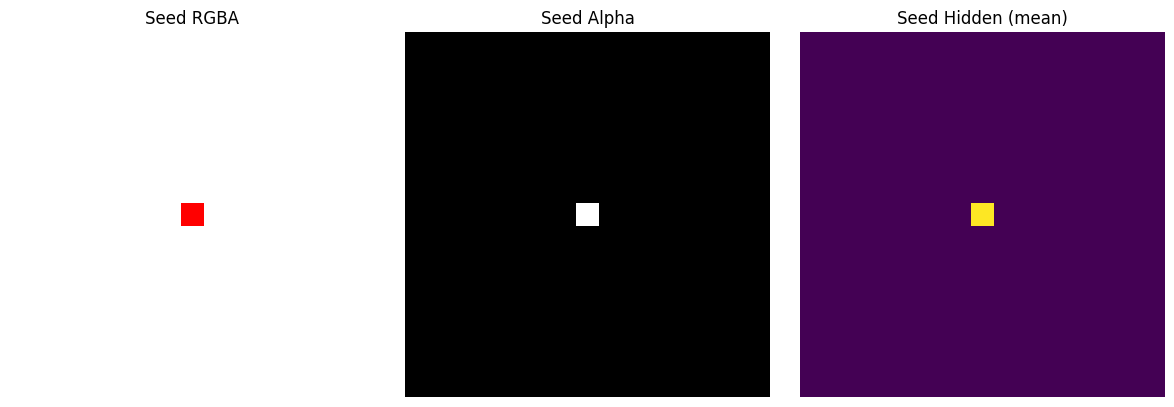

In [7]:
# Visualize seed
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# RGBA
axes[0].imshow(np.clip(seed[..., :4], 0, 1))
axes[0].set_title('Seed RGBA')
axes[0].axis('off')

# Alpha channel
axes[1].imshow(seed[..., 3], cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Seed Alpha')
axes[1].axis('off')

# Hidden channels (mean)
axes[2].imshow(seed[..., 15:].mean(axis=-1), cmap='viridis')
axes[2].set_title('Seed Hidden (mean)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Create Target Formations

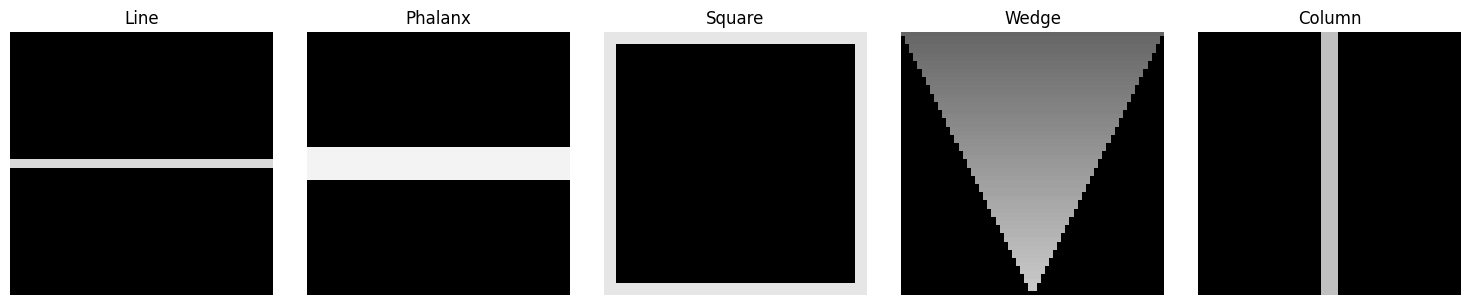

In [8]:
# Create all formation targets
targets = {
    'line': FormationTargets.line(GRID_SIZE, GRID_SIZE),
    'phalanx': FormationTargets.phalanx(GRID_SIZE, GRID_SIZE, depth=8),
    'square': FormationTargets.square(GRID_SIZE, GRID_SIZE, thickness=3),
    'wedge': FormationTargets.wedge(GRID_SIZE, GRID_SIZE),
    'column': FormationTargets.column(GRID_SIZE, GRID_SIZE, col_width=4),
}

# Visualize targets
fig, axes = plt.subplots(1, len(targets), figsize=(15, 3))

for ax, (name, target) in zip(axes, targets.items()):
    ax.imshow(target[..., 3], cmap='gray', vmin=0, vmax=1)
    ax.set_title(name.capitalize())
    ax.axis('off')

plt.tight_layout()
plt.show()

## Phase 1: Static Formation Learning

In [9]:
# Create optimizer
optimizer = create_optimizer(
    learning_rate=config.learning_rate,
    gradient_clip=config.gradient_clip
)

# Create training state
state = train_state.TrainState.create(
    apply_fn=child_nca.apply,
    params=params,
    tx=optimizer
)

# Create pool
pool = NCAPool(seed, config.pool_size)

# Target formation for Phase 1
target = targets['line']

In [10]:
# JIT-compiled training step
@partial(jax.jit, static_argnums=(4,))
def train_step(state, batch, target, key, num_steps):
    """Single training step."""
    def loss_fn(params):
        keys = jax.random.split(key, num_steps)
        
        def step(carry, subkey):
            return child_nca.apply({'params': params}, carry, subkey), None
        
        final, _ = jax.lax.scan(step, batch, keys)
        loss = jnp.mean((final[..., :4] - target) ** 2)
        return loss, final
    
    (loss, outputs), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    grads = normalize_gradients(grads)
    state = state.apply_gradients(grads=grads)
    
    return state, loss, outputs

In [ ]:
# Phase 1 training loop
print("="*60)
print("PHASE 1: Static Formation Learning")
print("="*60)

phase1_losses = []
phase1_times = []

for epoch in range(PHASE1_EPOCHS):
    start_time = time.time()
    
    key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
    
    # Sample from pool
    indices, batch = pool.sample(config.batch_size, subkey1)
    
    # Apply damage after warmup
    if epoch > config.damage_start_epoch:
        batch = pool.apply_damage(batch, config.damage_samples, subkey2)
    
    # Random step count [64, 96]
    num_steps = int(jax.random.randint(subkey3, (), config.min_steps, config.max_steps + 1))
    
    # Train step
    state, loss, outputs = train_step(state, batch, target, subkey3, num_steps)
    
    # Compute per-sample losses for pool update
    per_sample_losses = jnp.mean((outputs[..., :4] - target) ** 2, axis=(1, 2, 3))
    
    # Update pool
    pool.update(indices, outputs, per_sample_losses)
    
    elapsed = time.time() - start_time
    phase1_losses.append(float(loss))
    phase1_times.append(elapsed)
    
    if epoch % config.log_interval == 0:
        print(f"Epoch {epoch:4d}: loss = {loss:.6f}, time = {elapsed:.3f}s")

print(f"\nPhase 1 complete. Final loss: {phase1_losses[-1]:.6f}")

PHASE 1: Static Formation Learning
Epoch    0: loss = 0.029229, time = 15.082s


In [ ]:
# Plot Phase 1 training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
axes[0].plot(phase1_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Phase 1: Formation Loss')
axes[0].set_yscale('log')

# Smoothed
window = 50
smoothed = np.convolve(phase1_losses, np.ones(window)/window, mode='valid')
axes[0].plot(range(window-1, len(phase1_losses)), smoothed, 'r-', alpha=0.7, label='Smoothed')
axes[0].legend()

# Time per epoch
axes[1].plot(phase1_times)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Time (s)')
axes[1].set_title('Phase 1: Time per Epoch')

plt.tight_layout()
plt.show()

In [ ]:
# Test the trained model
key, subkey = jax.random.split(key)
test_state = seed

# Run forward
trajectory = [test_state]
for i in range(100):
    key, subkey = jax.random.split(key)
    test_state = child_nca.apply({'params': state.params}, test_state, subkey)
    if i % 10 == 0:
        trajectory.append(test_state)

# Visualize evolution
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (ax, frame) in enumerate(zip(axes.flat, trajectory)):
    ax.imshow(np.clip(frame[..., :4], 0, 1))
    ax.set_title(f'Step {i*10}')
    ax.axis('off')

plt.suptitle('Phase 1: Formation Evolution')
plt.tight_layout()
plt.show()

## Phase 2: Multi-Formation Transitions

Train the model to switch between different formations.

In [ ]:
# Phase 2 training
print("\n" + "="*60)
print("PHASE 2: Multi-Formation Transitions")
print("="*60)

# Reset pool with trained states
pool = NCAPool(seed, config.pool_size)

# Formation names for logging
formation_names = list(targets.keys())

phase2_losses = []
phase2_formations = []

for epoch in range(min(PHASE2_EPOCHS, 500)):  # Shorter for demo
    key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)
    
    # Random target formation
    target_idx = int(jax.random.randint(subkey1, (), 0, len(formation_names)))
    target = targets[formation_names[target_idx]]
    
    # Sample from pool
    indices, batch = pool.sample(config.batch_size, subkey2)
    
    # Damage augmentation
    if epoch > config.damage_start_epoch:
        batch = pool.apply_damage(batch, config.damage_samples, subkey3)
    
    # Random steps
    num_steps = int(jax.random.randint(subkey4, (), config.min_steps, config.max_steps + 1))
    
    # Train
    state, loss, outputs = train_step(state, batch, target, subkey4, num_steps)
    
    # Update pool
    per_sample_losses = jnp.mean((outputs[..., :4] - target) ** 2, axis=(1, 2, 3))
    pool.update(indices, outputs, per_sample_losses)
    
    phase2_losses.append(float(loss))
    phase2_formations.append(target_idx)
    
    if epoch % config.log_interval == 0:
        print(f"Epoch {epoch:4d}: loss = {loss:.6f}, target = {formation_names[target_idx]}")

print(f"\nPhase 2 complete. Final loss: {phase2_losses[-1]:.6f}")

## Save Trained Model

In [ ]:
# Save model checkpoint
import pickle
from pathlib import Path

checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

checkpoint = {
    'params': state.params,
    'config': {
        'grid_size': GRID_SIZE,
        'num_channels': NUM_CHANNELS,
        'hidden_dim': 128,
    },
    'metrics': {
        'phase1_losses': phase1_losses,
        'phase2_losses': phase2_losses,
    }
}

with open(checkpoint_dir / 'battle_nca_trained.pkl', 'wb') as f:
    pickle.dump(checkpoint, f)

print(f"Model saved to {checkpoint_dir / 'battle_nca_trained.pkl'}")

## Summary

This notebook demonstrated:
1. **Phase 1**: Training the NCA to grow and maintain a single formation (line)
2. **Phase 2**: Training on multiple formations for goal-conditioned behavior

**Next steps:**
- See `02_evaluation.ipynb` for model evaluation and metrics
- See `03_visualization.ipynb` for animations and detailed visualizations
- For Phase 3 (combat dynamics), use the `HierarchicalNCA` with two armies